### 1.Import library

In [2]:
from model.model import EncoderCNN, DecoderRNN
from prepare_data import CaptioningData
import torch
import pandas as pd
from torchtext.vocab import Vocab
from collections import defaultdict
from torch_snippets import *
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence

### 2.Create a vocabulary of all unique words 

In [3]:
data = pd.read_csv("./data.csv")
data.sample(5)

,dataset_id,image_id,annotator_id,caption,train
92444,open_images,1674b6a3e299fe1f,16,In this image we can see many people sitting o...,True
53530,open_images,a37e6dc66d79803f,39,In this picture we can observe a vehicle on th...,True
59196,open_images,8961dade32f5ebb4,97,In this image I can see group of people sittin...,True
57402,open_images,729fcbd90c36486c,53,In the image in the center we can see few diff...,True
62546,open_images,0eac4d459850a36c,97,In this image I can see few people standing an...,True


In [5]:
all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
# Reshape 2D list to 1D list
one_dimensional_list = [word for sublist in all_tokens for word in sublist]

# Get unique words using set and convert back to list
unique_words = list(set(one_dimensional_list))
unique_words.insert(0,'<pad>')
unique_words.insert(1,'<unk>')
unique_words.insert(2,'<start>')
unique_words.insert(3,'<end>')

In [6]:
class Vocab: pass

vocab = Vocab()
vocab.itos = unique_words

def create_stoi_dict(vocab):
    stoi_dict = defaultdict()
    stoi_dict['<pad>'] = 0
    for i, s in enumerate(vocab.itos[1:], start=1):
        stoi_dict[s] = i
    return stoi_dict

vocab.stoi = create_stoi_dict(vocab)

### 3.Define the training and validation dataset and data loader

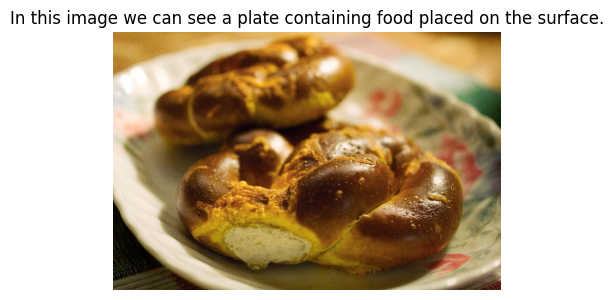

tensor([    2,  4675,  3711,  9542, 12961, 13073, 11989,  8068,  2685,  2997,
        10573,  4710,  4429, 10804,  2882,     3])

In [7]:
trn_ds = CaptioningData('train-images', data[data['train']], vocab)
val_ds = CaptioningData('val-images', data[~data['train']], vocab)
image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)

In [14]:
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)
inspect(*next(iter(trn_dl)), names='images,targets,lengths')

══════════════════════════════════════════════════════════════════
tensor([[[[-0.2513, -0.2684, -0.2513,  ..., -0.5082, -0.4739, -0.4568],
          [-0.2513, -0.2513, -0.2342,  ..., -0.4739, -0.4397, -0.4226],
          [-0.2171, -0.2171, -0.2342,  ..., -0.4397, -0.4226, -0.4054],
          ...,
          [-1.0904, -1.0904, -1.0904,  ..., -1.9980, -2.0152, -2.0152],
          [-1.1418, -1.1589, -1.1418,  ..., -1.9980, -2.0152, -2.0323],
          [-1.4329, -1.4500, -1.4500,  ..., -1.9809, -1.9980, -1.9980]],

         [[-0.3725, -0.3901, -0.3725,  ..., -0.6877, -0.6527, -0.6352],
          [-0.3725, -0.3725, -0.3550,  ..., -0.6527, -0.6176, -0.6001],
          [-0.3550, -0.3550, -0.3550,  ..., -0.6176, -0.6001, -0.5826],
          ...,
          [-1.5630, -1.5630, -1.5630,  ..., -1.9132, -1.9307, -1.9307],
          [-1.5630, -1.5980, -1.5630,  ..., -1.9132, -1.9307, -1.9482],
          [-1.6856, -1.6856, -1.6856,  ..., -1.8957, -1.9132, -1.9132]],

         [[-0.3753, -0.3578, -0.305

### 4. Train model

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = EncoderCNN(256).to(device)
print(summary(encoder,torch.zeros(32,3,224,224).to(device)))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

In [18]:
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [19]:
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss

In [20]:
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1, vocab).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
n_epochs = 1
log = Report(n_epochs)

In [ ]:
for epoch in range(n_epochs):
    if epoch == 5: optimizer = torch.optim.AdamW(params, lr=1e-4)
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

log.plot_epochs(log=True)

### 5.Predict

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image

@torch.no_grad()
def load_image_and_predict(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    show(org_image, title=sentence)
    return sentence

files = Glob('val-images')
for _ in range(5):
    load_image_and_predict(choose(files))